# Lab 3 — Clustering

In [133]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from itertools import combinations
from collections import Counter
import random

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline
plt.style.use("ggplot")

In [134]:
from bokeh.io import show, output_notebook, gridplot
from bokeh.charts import Bar
from bokeh.models import Div
from bokeh.layouts import column
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

## 3.11 Clustering Tags

Load the data and prepare the points

In [135]:
with open('data.txt', 'r') as source_file:
    data = json.loads(json.load(source_file)) # Why is this neeeded?

In [136]:
tags = [tag for tag in data]
coordinates = np.array([data[tag] for tag in tags])

We also need to perform PCA on the coordinates in order to be able to visualize it on a lower dimensional space: here we want to project 5 dimensional vectors on a bidimensional space.

In [137]:
centered = coordinates - np.mean(coordinates, axis=0)
cov = (centered.T @ centered) / centered.shape[0]
inc_vals, inv_vecs = np.linalg.eigh(cov)
inc_vals = inc_vals[::-1]
inv_vecs = np.fliplr(inv_vecs)

In [138]:
colors = {
    0: '#ff0000',
    1: '#00ff00',
    2: '#0000ff',
    3: '#ffff00',
    4: '#551a8b'
}

def visualize(k, data, tags, projf):
    """
    Performes k means on the provided data using k clusters
    and creates a bidimensional plot. The transformation of the
    data to a 2d space is performed by the provided projection
    function.
    """
    clus = KMeans(n_clusters=k).fit(data)
    
    coords2d = projf(data)
    source = ColumnDataSource(
        data = {
            'x' : [x[0] for x in coords2d],
            'y' : [x[1] for x in coords2d],
            'color' : [colors[x] for x in clus.labels_],
            'tagname' : tags
        }    
    )
    centroids_coords = [projf(centr) for centr in clus.cluster_centers_]
    centroids = ColumnDataSource(
        data = {
            'x' : [centr[0] for centr in centroids_coords],
            'y' : [centr[1] for centr in centroids_coords]
        }
    )

    hover = HoverTool(
            tooltips=[('Tag name', '@tagname')]
    )
    tools = [WheelZoomTool(), ResetTool(), PanTool(), SaveTool(), hover]
    p = figure(tools=tools, width=400, height=400, title='K = '+ str(k))
    p.circle('x', 'y', source=source, color='color')
    p.asterisk('x', 'y', size=30,source=centroids, color='#000000')
    
    return p

def four_plots(data, tags, projection_function):
    """ Draws a grid plot consisting of four kmeans 2d plots
    using k between 2 and 5.
    """
    plots = [visualize(k, data, tags, projection_function) for k in range(2,6)]
    plots = [plots[:2], plots[2:]]
    return gridplot(plots)

For each possible combination of length 2 of eingenvectors (aka principal directions) we plot the clustered data using, for each combination, $k\in \{2,3,4,5\}$

In [7]:
#Try projecting on on different principal directions
for i, j in combinations(range(5), 2):
    xy = inv_vecs[:, [i, j]]
    projection_function = lambda point: point @ xy
    p = four_plots(coordinates, tags, projection_function)
    title = 'Using components associated to eigenvalues number' + str((i, j))
    show(column(Div(text=title), p))

The principal directions that separate the cluster well are those used in the eigth plot. (2, 3)

## 3.12 Clustering Movies

### Algorithm Implementation

We try to write a generic function implementing the k-medioids algorithm

In [8]:
def k_medioids(points, k, dist_f, max_dist = 1, max_iterations=200):
    """
    Runs the k-medioids algorithm on the provided (hashable) points.
    
    :param points:   the points to cluster. Points must be comparable and hashable
    :param k:        the number of clusters to create
    :param dist_f:   distance function taking two elements of points and returning
                        a real distance.
    :param max_dist: the maximal distance between two points (needed for min search)
    :max_iterations: the maximal number of iterations the algorithm should run
    """
    medioids = random.sample(points, k) # Random Init
    n_iter = 0 # Count the number of performed iterations
    clusters = [] # Store the clusters to be able to return them
    converged = False
    while not converged and n_iter < max_iterations:
        converged = True
        clusters = [set() for i in range(k)] # Initialize clusters
        
        # Assign points to clusters
        for x in points:
            closest_medioid_index = -1
            dist_from_closest = max_dist
            for i in range(k):
                dist = dist_f(x, medioids[i])
                if dist < dist_from_closest:
                    dist_from_closest = dist
                    closest_medioid_index = i
            clusters[closest_medioid_index].add(x)
            
        # Recompute medioids
        for i in range(k):
            closest_point = None
            dist_from_closest = max_dist * len(clusters[i])
            for x in clusters[i]:
                sum_of_dists = 0
                for y in clusters[i]:
                    sum_of_dists += dist_f(x, y)
                if sum_of_dists < dist_from_closest:
                    dist_from_closest = sum_of_dists
                    closest_point = x
            if medioids[i] != closest_point:
                converged = False
                medioids[i] = closest_point
        n_iter += 1
    return clusters, medioids, n_iter

### Clustering `most-rated.pickle`

The algorithm ready, it is time to prepare the data:

First we retrieve the movie IDs associated to the the set of genres they fit in:

In [9]:
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 1

{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}


In [10]:
all_ids_to_genres = sc.textFile("/ix/ml-20m/movies.txt")\
           .map(json.loads)\
           .map(lambda j: (j['movieId'], set(j['genres'])))\
           .collectAsMap()

and then we read the movies in `most-rated.pickle` and extract, for each of them, its genres:

In [11]:
with open('most-rated.pickle', 'rb') as f:
    most_rated = pickle.load(f)

In [12]:
id_to_title = {t[0]: t[1] for t in most_rated}

In [13]:
ids_to_genres = {movie_id : all_ids_to_genres[movie_id] for movie_id in id_to_title}

We can now define the jaccard distance as a generic function taking two sets. 

Finally we define the distance function which will pass to `k-medioids` as a closure bringing with itself the `dict` associating movie IDs to the set of genres they fit in:

In [14]:
jaccard_dist = lambda A, B : 1 - (len(A & B) / len(A | B))
dist_f = lambda p1, p2: jaccard_dist(ids_to_genres[p1], ids_to_genres[p2])

We are now able to cluster the movies in `most-rated.pickle` using $k=2$:

In [15]:
clusters, medioids, n_iter = k_medioids(list(ids_to_genres.keys()), 2, dist_f)

### Visualization

In [17]:
def count(ls):
    c = Counter()
    for x in ls:
        c[x] += 1
    return c

In [18]:
genres_frequencies_per_cluster = [count([genre for movie in C for genre in ids_to_genres[movie]]) for C in clusters]

In [20]:
genres_frequencies_per_cluster

[Counter({'Action': 33,
          'Adventure': 43,
          'Animation': 34,
          'Children': 47,
          'Comedy': 347,
          'Crime': 67,
          'Documentary': 1,
          'Drama': 289,
          'Fantasy': 54,
          'Film-Noir': 3,
          'Horror': 21,
          'IMAX': 3,
          'Musical': 32,
          'Mystery': 22,
          'Romance': 186,
          'Sci-Fi': 13,
          'Thriller': 29,
          'War': 27,
          'Western': 12}),
 Counter({'Action': 257,
          'Adventure': 185,
          'Animation': 28,
          'Children': 35,
          'Comedy': 44,
          'Crime': 94,
          'Documentary': 5,
          'Drama': 159,
          'Fantasy': 59,
          'Film-Noir': 10,
          'Horror': 51,
          'IMAX': 19,
          'Musical': 12,
          'Mystery': 62,
          'Romance': 12,
          'Sci-Fi': 156,
          'Thriller': 241,
          'War': 23,
          'Western': 11})]

In [36]:
len(genres_frequencies_per_cluster[0]) == len(genres_frequencies_per_cluster[1])

True

In [105]:
genres = list({genre for cluster in genres_frequencies_per_cluster for genre in cluster})
c0_ratios = []
c1_ratios = []

for genre_index in range(len(genres)):
    c0 = genres_frequencies_per_cluster[0].get(genres[genre_index], 0)
    c1 = genres_frequencies_per_cluster[1].get(genres[genre_index], 0)
    tot = c0 + c1
    c0_ratios.append((genre_index, c0 / tot * 100))
    c1_ratios.append((genre_index, c1 / tot * 100))

sorted_c0 = sorted(c0_ratios, key=lambda t: t[1])
sorted_genres = [genres[index] for index, percentage in sorted_c0]
sorted_c1 = [c1_ratios[index][1] for index, percentage in sorted_c0]
sorted_c0 = [percentage for index, percentage in sorted_c0]

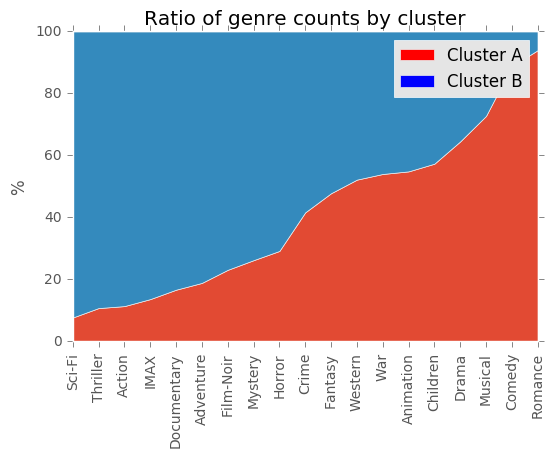

In [126]:
stack1, stack2 = plt.stackplot(ax, sorted_c0, sorted_c1)
axes = plt.gca()
axes.set_ylim([0, 100])
plt.ylabel('%')
plt.title('Ratio of genre counts by cluster')
plt.xticks(ax, sorted_genres, rotation=90)

plt.legend((p1[0], p2[0]), ('Cluster A', 'Cluster B'))
plt.show()

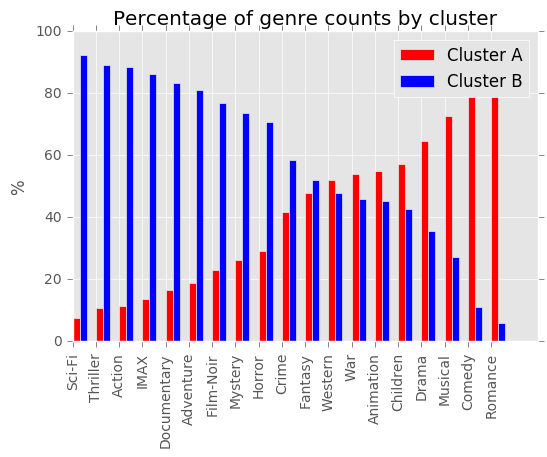

In [131]:
p1 = plt.bar(ax, sorted_c0, 0.3, color='r')
p2 = plt.bar(ax+0.3, sorted_c1, 0.3, color='b')
plt.ylabel('%')
plt.title('Percentage of genre counts by cluster')
plt.xticks(ax, sorted_genres, rotation=90)
plt.legend((p1[0], p2[0]), ('Cluster A', 'Cluster B'))
plt.show()

We can see how the algorithm divided the movies into two groups: one related to action, technology and special effects and the other one more connected to the concepts of feelings: drama, romance, war and children.